In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sp_signal
from pymultifracs.viz import plot_psd
from pymultifracs import mfa, wavelet_analysis
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error


### 🎯 Experiment Overview: Signal Composition vs Decomposition Behavior

| Signal Name                   | Composition Details                                  | Known # of Components (Modes) |
|-------------------------------|-----------------------------------------------------|-------------------------------|
| **Pure Oscillations**         | 6 Hz + 10 Hz + 30 Hz + 80 Hz                         | 4                             |
| **Pure Oscillations + 1/f**    | Same as above + 1/f noise                           | 4 + noise                     |
| **MRW Modulated Oscillations** | MRW modulated 6, 10, 30, 80 Hz                       | 4 modulated                   |
| **MRW + 1/f**                  | MRW modulated 6, 10, 30, 80 Hz + 1/f noise           | 4 modulated + noise           |
| **MRW (H, lam) + 1/f**         | MRW (H=0.8, lam=0.05) modulated 6, 10, 30, 80 Hz + 1/f noise | 4 modulated + noise |

### 🧪 Objective:
- Set **Nmodes = 4** in all decompositions.
- Observe how **EMD**, **VMD**, and **VMDtransformer** behave:
  - Do they **stop at 4 modes** as expected?
  - Do they **capture the known components** or **over/under decompose**?


In [3]:
gen_path = os.path.abspath(os.path.join(os.getcwd(), '..','03_signal_generation'))
sys.path.append(gen_path)

from signal_gen import generate_synthetic_neural_signal
from decomposition_and_features import extract_mode_features, plot_signal_and_modes, plot_mvmd_grid,run_all_decompositions

In [4]:
# 1. Pure Oscillations (no MRW, no noise)
pure = generate_synthetic_neural_signal(
    add_fbm_noise=False,
    add_powerline=False,
    c1=0.0,
    c2=0.0
)

# 2. MRW-Modulated Oscillations (no noise)
mrw_modulated = generate_synthetic_neural_signal(
    add_fbm_noise=False,
    add_powerline=False,
    c1=0.7,
    c2=-0.04
)

# 3. MRW + FBM Noise (most realistic)
mrw_with_fbm = generate_synthetic_neural_signal(
    add_fbm_noise=True,
    add_powerline=False,
    c1=0.7,
    c2=-0.04,
    H=0.98  # Hurst exponent from MEG analysis
)


Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 1.50 Hz (-6 dB cutoff frequency: 0.75 Hz)
- Filter length: 551 samples (2.204 s)

Setting up high-pass filter at 2.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 413 samples (1.652 s)

Setting up high-pass filter at 7.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) me

In [47]:
mod  = generate_synthetic_neural_signal(
    add_fbm_noise=False,
    add_powerline=False,
    c1=0.7,
    c2=-0.04
)

Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 1.50 Hz (-6 dB cutoff frequency: 0.75 Hz)
- Filter length: 551 samples (2.204 s)

Setting up high-pass filter at 2.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 413 samples (1.652 s)

Setting up high-pass filter at 7.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) me

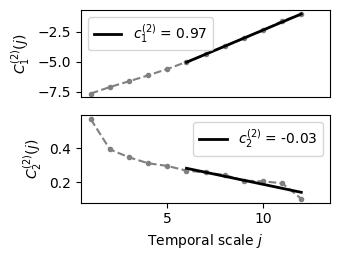

In [58]:
pwt = mfa(wavelet_analysis(mod["modulator"], 'db4').integrate(1).get_leaders(2), [(6, 12)])
pwt.cumulants.plot()

In [59]:
def plot_signals(signal_dicts, titles, fs=500, duration=300.0, max_points=None):
    """
    Plots multiple signals for comparison with optional downsampling.

    Parameters:
    - signal_dicts: list of dictionaries containing signal data.
    - titles: list of plot titles.
    - fs: sampling frequency in Hz.
    - duration: duration in seconds to plot.
    - max_points: maximum number of points to display (default None = no limit).
    """
    n_samples_to_plot = int(fs * duration)
    t_full = signal_dicts[0]['time'][:n_samples_to_plot]

    # Determine downsampling step if needed
    step = max(1, int(n_samples_to_plot / max_points)) if max_points is not None else 1

    t = t_full[::step]

    plt.figure(figsize=(15, 10))
    for i, (signal_dict, title) in enumerate(zip(signal_dicts, titles)):
        y_full = signal_dict['final_signal'][:n_samples_to_plot]
        y = y_full[::step]
        plt.subplot(len(signal_dicts), 1, i + 1)
        plt.plot(t, y)
        plt.title(title)
        plt.ylabel("Amplitude")
        if i == len(signal_dicts) - 1:
            plt.xlabel("Time (s)")
    plt.tight_layout()
    plt.show()


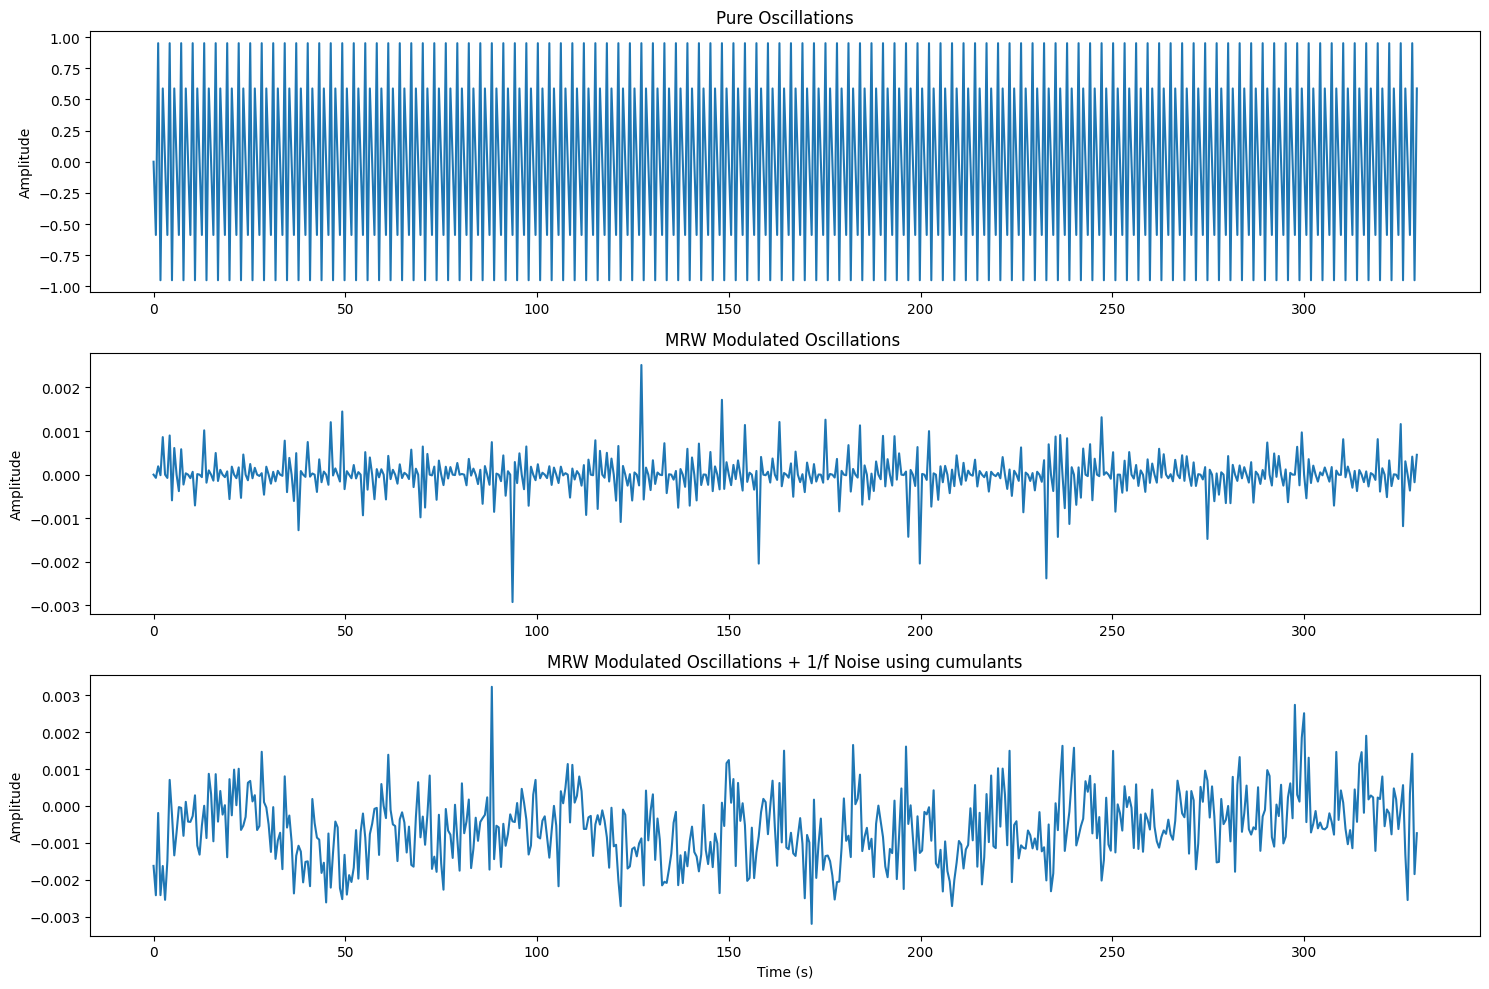

In [60]:
# Call plotting function with your signals
plot_signals(
    [pure, mrw_modulated, mrw_with_fbm],
    ["Pure Oscillations",
     "MRW Modulated Oscillations ",
     "MRW Modulated Oscillations + 1/f Noise using cumulants"],
     max_points=1000
)


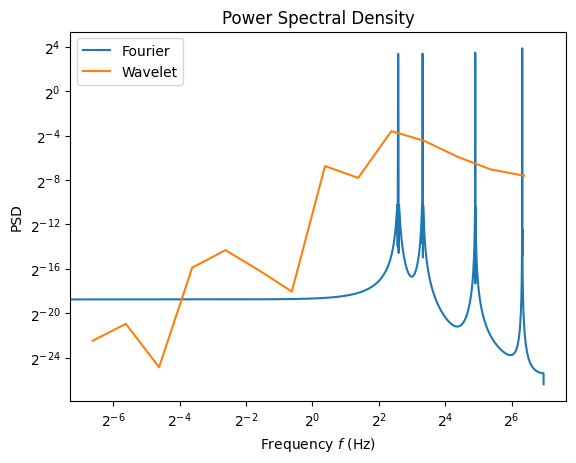

In [61]:
# Plot 1: Pure Oscillations
plot_psd(pure['final_signal'], fs=250)


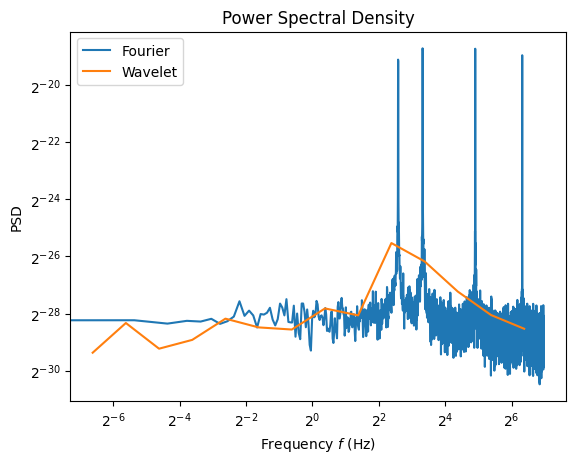

In [10]:
# Plot 2: MRW Modulated Oscillations
plot_psd(mrw_modulated['final_signal'], fs=250)



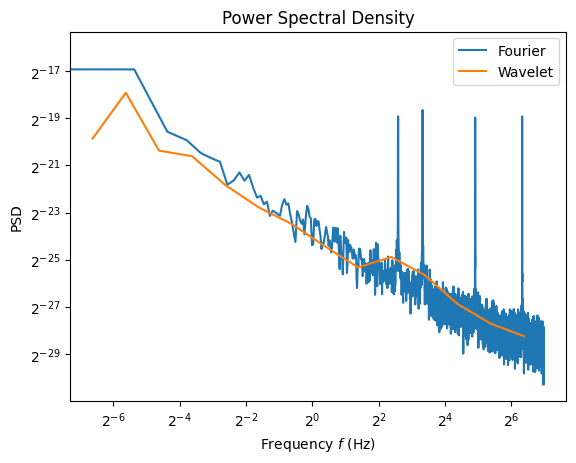

In [11]:
# Plot 3: MRW + FBM Noise
plot_psd(mrw_with_fbm['final_signal'], fs=250)

In [62]:
def analyze_and_save_signals(
    signals, 
    signal_names, 
    sfreq=250, 
    max_plot_points=None,
    Nmodes=2, 
    methods=None, 
    output_dir='features_output',
    # Optional decomposition parameters
    eemd_trials=100,
    vmd_alpha=200,
    vmd_tau=0,
    vmd_DC=0,
    vmd_init=1,
    vmd_tol=1e-7
):
    """
    Analyze multiple signals with decomposition methods and save the results.

    Optional parameters let you control VMD and EEMD behavior.
    """
    if methods is None:
        methods = ["EMD", "VMD", "VMDtransformer"]

    if signal_names is None or len(signal_names) != len(signals):
        raise ValueError("Please provide signal_names matching the number of signals.")

    os.makedirs(output_dir, exist_ok=True)

    for idx, x in enumerate(signals):
        name = signal_names[idx]
        print(f"\n🚀 Processing: {name}")

        x = x - np.mean(x)
        b, a = sp_signal.butter(4, 40 / (0.5 * sfreq), btype='low')
        x = sp_signal.filtfilt(b, a, x)

        # Forward parameters to run_all_decompositions
        feats_dict, modes_dict = run_all_decompositions(
            x, sfreq, Nmodes, methods=methods, 
            eemd_trials=eemd_trials,
            vmd_alpha=vmd_alpha,
            vmd_tau=vmd_tau,
            vmd_DC=vmd_DC,
            vmd_init=vmd_init,
            vmd_tol=vmd_tol,
            return_modes=True
        )

        for method, features in feats_dict.items():
            method_dir = os.path.join(output_dir, method)
            os.makedirs(os.path.join(method_dir, "metrics"), exist_ok=True)
            os.makedirs(os.path.join(method_dir, "modes"), exist_ok=True)
            os.makedirs(os.path.join(method_dir, "figures"), exist_ok=True)

            save_path = os.path.join(method_dir, "metrics", f'{name}.csv')
            if isinstance(features, dict) and 'labels' in features and 'values' in features:
                header = ','.join(features['labels'])
                values = np.array([features['values']])
                np.savetxt(save_path, values, delimiter=',', fmt='%s', header=header, comments='')
            else:
                print(f"⚠️ Skipping {method} on {name} due to missing 'labels' or 'values'.")

            if method in modes_dict:
                modes = modes_dict[method]
                np.save(os.path.join(method_dir, "modes", f'{name}_modes.npy'), modes)
                plot_signal_and_modes(x, sfreq, modes, method, name, output_dir, max_plot_points)


In [63]:
signal_list = [
    pure['final_signal'],
    mrw_modulated['final_signal'],
    mrw_with_fbm['final_signal']
]

signal_names = [
    "pure",
    "mrw_modulated",
    "mrw_with_fbm"
]

In [ ]:
# Custom parameters for decomposition methods
analyze_and_save_signals(
    signal_list,
    signal_names,
    sfreq=500,
    Nmodes=4,
    max_plot_points=500 
    #methods=['EMD', 'VMD'],
    #eemd_trials=50,    # Fewer EEMD trials for speed
    #vmd_alpha=500,     # Stronger constraint on bandwidth
    #vmd_tau=1,         # Higher noise tolerance
    #vmd_DC=1,          # DC mode extraction
    #vmd_init=1,        # Initialization strategy
    #vmd_tol=1e-6       # Relaxed convergence tolerance
)



🚀 Processing: pure


In [ ]:


def summarize_decomposition_results_essential(signal_list, signal_names, sfreq, base_dir='features_output', methods_to_check=None,n_modes_to_use=None):
    """
    Lists all extracted modes and adds the number of modes per signal/method.
    """
    if methods_to_check is None:
        methods_to_check = ["EMD", "VMD", "VMDtransformer"]

    records = []

    for method in methods_to_check:
        for signal_name, original_signal in zip(signal_names, signal_list):
            mode_file = os.path.join(base_dir, method, "modes", f"{signal_name}_modes.npy")
            if not os.path.exists(mode_file):
                continue

            modes = np.load(mode_file)
            n_modes_extracted = modes.shape[0]

            mse_full = compute_reconstruction_error(original_signal, modes)
            mse_first4 = compute_reconstruction_error(original_signal, modes, n_modes_to_use=n_modes_to_use)

            for idx, mode in enumerate(modes):
                feats, labels = extract_mode_features(mode, sfreq)
                feat_dict = dict(zip(labels, feats))

                record = {
                    "Method": method,
                    "Signal": signal_name,
                    "Mode Index": idx,
                    "Peak Frequency (Hz)": feat_dict.get("Ppeak", np.nan),
                    #"Band Energy (BM)": feat_dict.get("BM", np.nan),
                    #"Spectral Centroid": feat_dict.get("Cent", np.nan),
                    "Reconstruction MSE (Full)": mse_full,
                    "Reconstruction MSE (First 4 Modes)": mse_first4,
                    "Number of Extracted Modes": n_modes_extracted
                }
                records.append(record)

    df_summary = pd.DataFrame(records)
    return df_summary

In [23]:
from sklearn.metrics import mean_squared_error
import pandas as pd
from IPython.display import display, HTML


def compute_reconstruction_error(original_signal, modes, n_modes_to_use=None):
    """
    Compute the reconstruction error (MSE) between the original signal
    and the sum of the first n_modes_to_use modes (or all modes if None).
    """
    if n_modes_to_use is not None:
        modes_to_sum = modes[:n_modes_to_use]
    else:
        modes_to_sum = modes

    reconstructed = np.sum(modes_to_sum, axis=0)
    # mse = mean_squared_error(original_signal, reconstructed)


    mse = np.mean((original_signal - reconstructed) ** 2)
    var = np.var(original_signal)
    mse = mse / var if var > 0 else np.nan
    return mse


In [26]:
report_df = summarize_decomposition_results_essential(
    signal_list,
    signal_names,
    sfreq=250,
    n_modes_to_use=4
)

In [27]:
report_df = report_df[report_df["Method"].isin(["EMD", "VMDtransformer"])]
report_df.to_csv("decomposition_full_report.csv", index=False)


In [28]:
df_report = pd.read_csv("decomposition_full_report.csv")

df_report.style.set_table_attributes("style='display:inline'").set_table_styles([
    {'selector': 'table', 'props': [('max-height', '400px'), ('overflow-y', 'scroll'), ('display', 'block')]}
])

,Method,Signal,Mode Index,Peak Frequency (Hz),Reconstruction MSE (Full),Reconstruction MSE (First 4 Modes),Number of Extracted Modes
0,EMD,pure,0,10.000000,0.485049,0.485106,9
1,EMD,pure,1,6.000000,0.485049,0.485106,9
2,EMD,pure,2,2.000000,0.485049,0.485106,9
3,EMD,pure,3,0.054545,0.485049,0.485106,9
4,EMD,pure,4,0.039394,0.485049,0.485106,9
5,EMD,pure,5,0.036364,0.485049,0.485106,9
6,EMD,pure,6,0.030303,0.485049,0.485106,9
7,EMD,pure,7,0.021212,0.485049,0.485106,9
8,EMD,pure,8,0.003030,0.485049,0.485106,9
9,EMD,mrw_modulated,0,10.000000,0.890072,0.885434,5


In [40]:
# ========== CONFIGURATION ==========
from pymultifracs.utils import build_q_log


# Signal file (optional, for original signal)
# from your generation pipeline
# Replace with your actual signal if different
# Example: apply_mfa(mrw_modulated_with_noise['final_signal'], ...)
signal_to_analyze = signal_list[2]
  # Set this later if needed

# Path where the modes are saved
base_path = "features_output"
methods = ["VMDtransformer"]  # You can add "EMD" etc. here

# q values and scaling range (adjust as needed)
q_vals = build_q_log(0.1, 5, 20)
scaling_ranges = [[6, 11]]

In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pymultifracs.wavelet import wavelet_analysis
from pymultifracs.mf_analysis import mfa
from pymultifracs.utils import build_q_log



# ========== MFA FUNCTION ==========

def apply_mfa(signal, ch_label=""):
    """Apply MFA to a 1D signal and plot structure function, cumulants, and multifractal spectrum."""
    print(f"\n🔍 Applying MFA to {ch_label} — Length: {len(signal)}")

    # Step 1: Wavelet Transform
    WT = wavelet_analysis(signal, wt_name='db3')

    # Step 2: Compute p-leaders
    WTpL = WT.get_leaders(p_exp=2)

    # Step 3: Integrate across scales
    WTpL = WTpL.auto_integrate(scaling_ranges)

    # Step 4: MFA computation
    pwt = mfa(WTpL, scaling_ranges, weighted='Nj', q=q_vals)

    # Plot 1: ζ(q)
    plt.figure(figsize=(8, 4))
    pwt.structure.plot_scaling()
    plt.title(f"ζ(q) for {ch_label}")
    plt.grid()
    plt.show()

    # Plot 2: Cumulants
    plt.figure(figsize=(8, 4))
    pwt.cumulants.plot()
    plt.title(f"Cumulants for {ch_label}")
    plt.grid()
    plt.show()

    # Plot 3: D(h)
    plt.figure(figsize=(8, 4))
    pwt.spectrum.plot()
    plt.title(f"D(h) Spectrum for {ch_label}")
    plt.grid()
    plt.show()

    return pwt

# ========== LOAD MODES AND APPLY MFA ==========

def load_modes_and_apply_mfa(modes_filename, base_path=base_path, methods=methods):
    """Load modes from disk and apply MFA to each mode."""
    for method in methods:
        file_path = os.path.join(base_path, method, "modes", modes_filename)
        
        if not os.path.exists(file_path):
            print(f"⚠️ Missing: {file_path}")
            continue

        modes = np.load(file_path)  # shape = (n_modes, n_samples)
        print(f"\n📂 Loaded {method} modes — shape: {modes.shape}")
        
        for idx, mode in enumerate(modes):
            label = f"{method} | Mode {idx}"
            apply_mfa(mode, ch_label=label)



🔍 Applying MFA to Full Signal — Length: 82500


<Figure size 800x400 with 0 Axes>

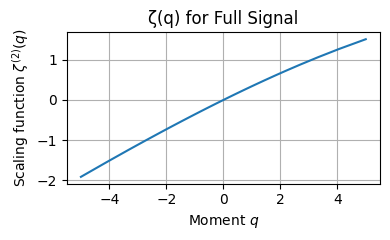

<Figure size 800x400 with 0 Axes>

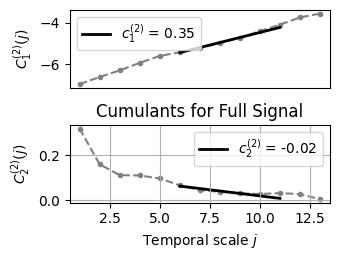

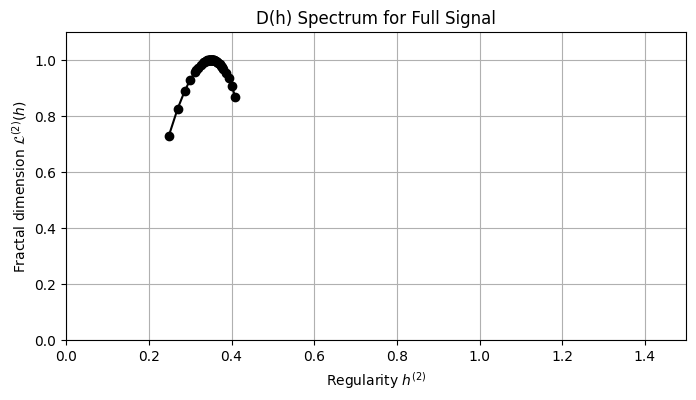


📂 Loaded VMDtransformer modes — shape: (6, 82500)

🔍 Applying MFA to VMDtransformer | Mode 0 — Length: 82500


<Figure size 800x400 with 0 Axes>

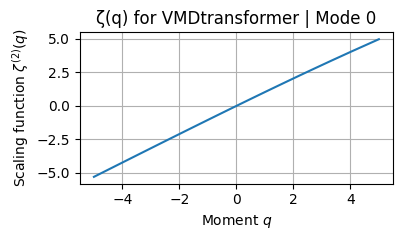

<Figure size 800x400 with 0 Axes>

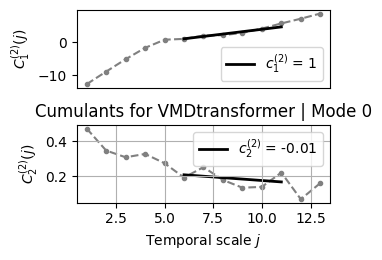

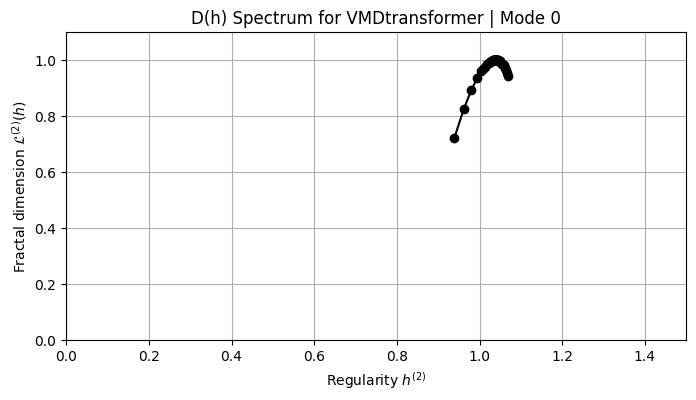


🔍 Applying MFA to VMDtransformer | Mode 1 — Length: 82500


<Figure size 800x400 with 0 Axes>

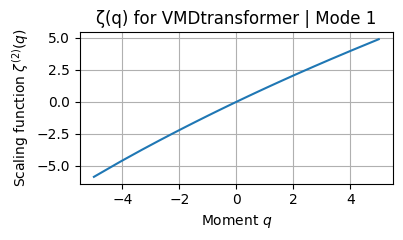

<Figure size 800x400 with 0 Axes>

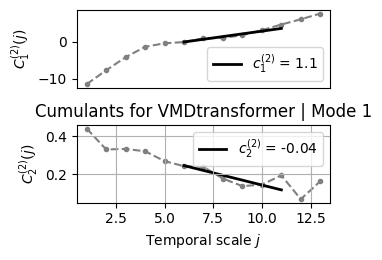

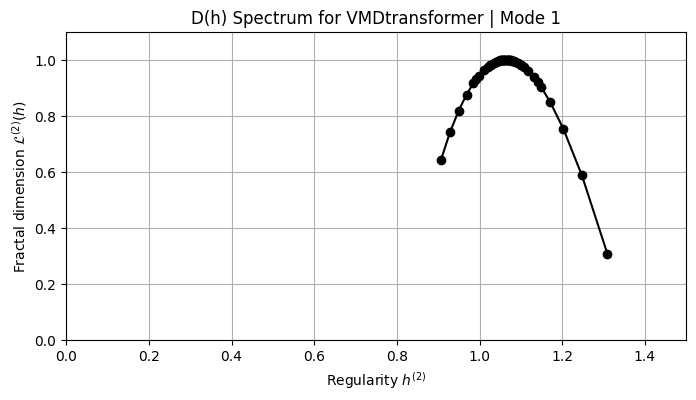


🔍 Applying MFA to VMDtransformer | Mode 2 — Length: 82500


<Figure size 800x400 with 0 Axes>

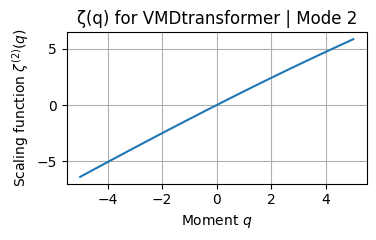

<Figure size 800x400 with 0 Axes>

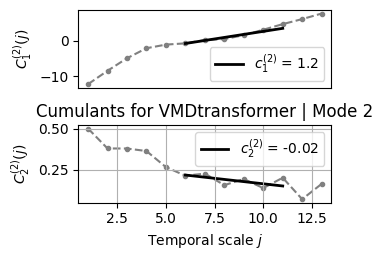

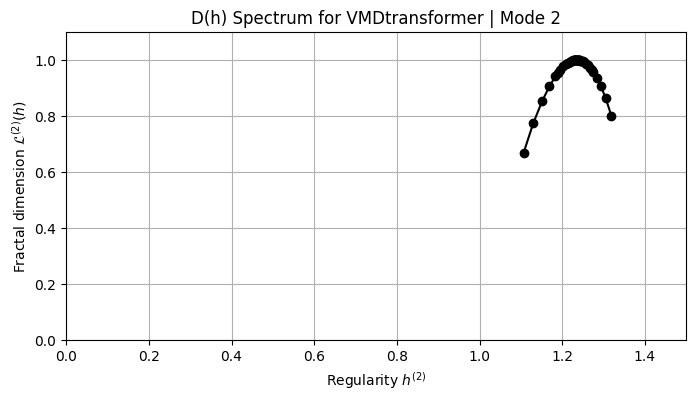


🔍 Applying MFA to VMDtransformer | Mode 3 — Length: 82500


<Figure size 800x400 with 0 Axes>

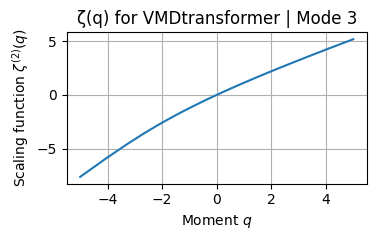

<Figure size 800x400 with 0 Axes>

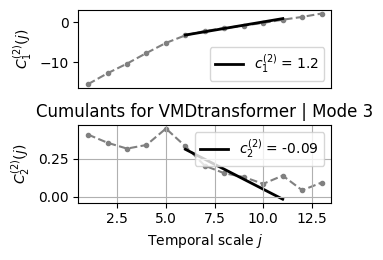

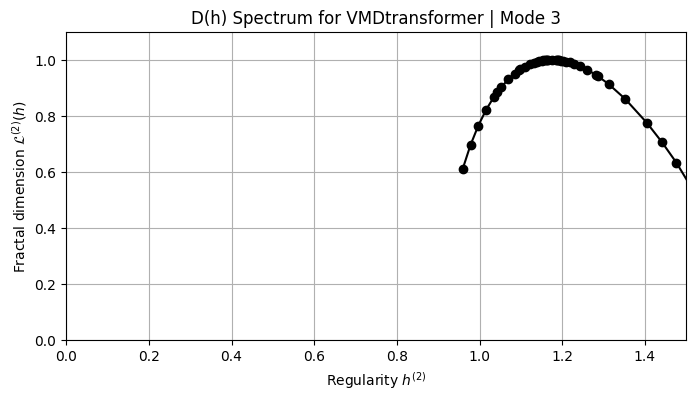


🔍 Applying MFA to VMDtransformer | Mode 4 — Length: 82500


<Figure size 800x400 with 0 Axes>

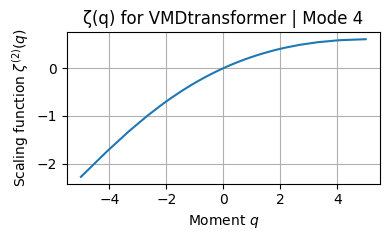

<Figure size 800x400 with 0 Axes>

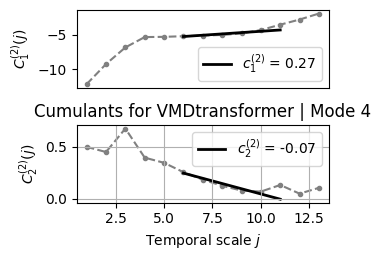

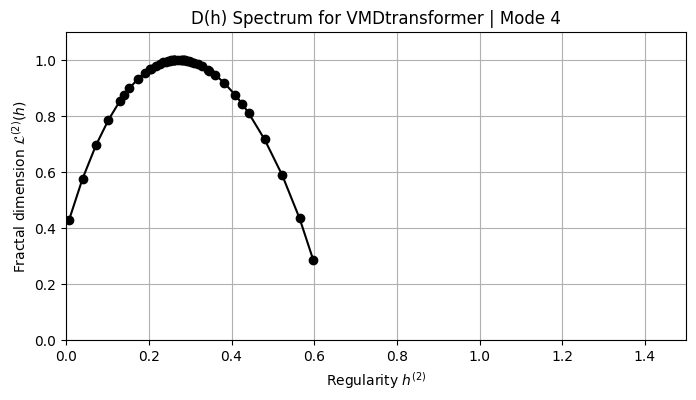


🔍 Applying MFA to VMDtransformer | Mode 5 — Length: 82500


<Figure size 800x400 with 0 Axes>

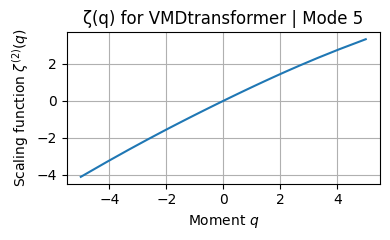

<Figure size 800x400 with 0 Axes>

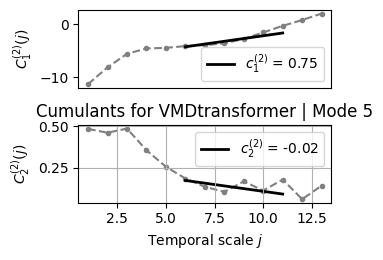

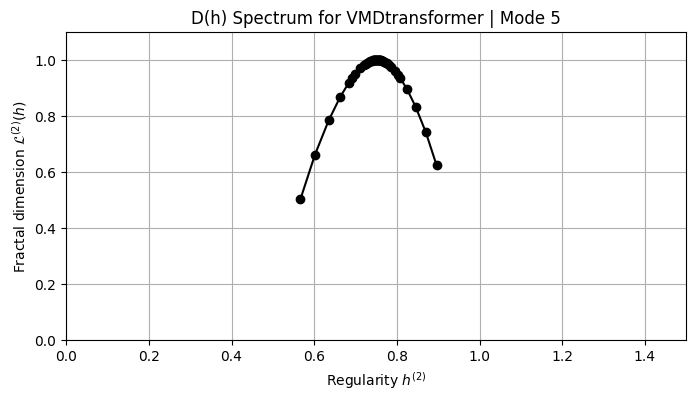

In [38]:
# ========== RUN ANALYSIS ==========

# Optional: Apply MFA to your full signal
apply_mfa(signal_to_analyze, ch_label="Full Signal")

# Apply MFA to modes from decomposition
load_modes_and_apply_mfa("mrw_modulated_modes.npy")



📂 Loaded VMDtransformer modes — shape: (8, 82500)

🔍 Applying MFA to VMDtransformer | Mode 0 — Length: 82500


<Figure size 800x400 with 0 Axes>

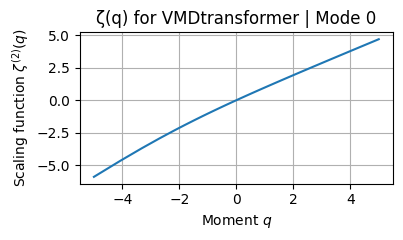

<Figure size 800x400 with 0 Axes>

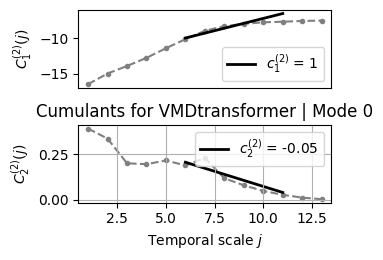

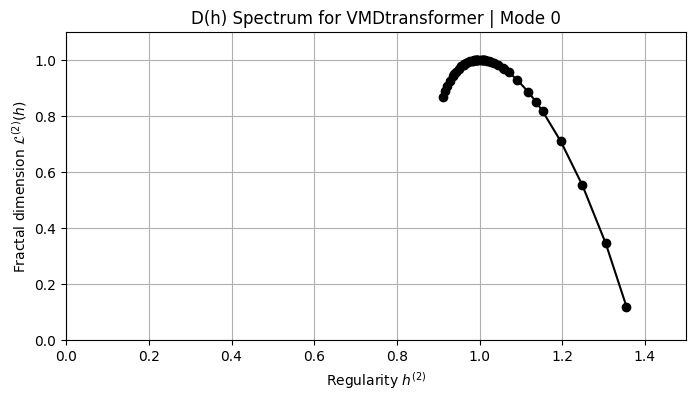


🔍 Applying MFA to VMDtransformer | Mode 1 — Length: 82500


<Figure size 800x400 with 0 Axes>

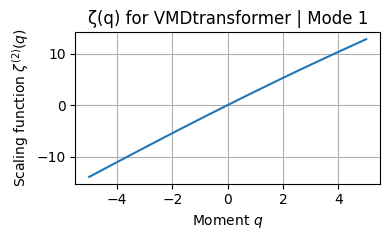

<Figure size 800x400 with 0 Axes>

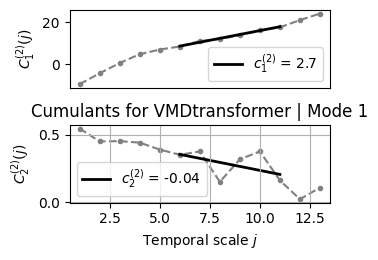

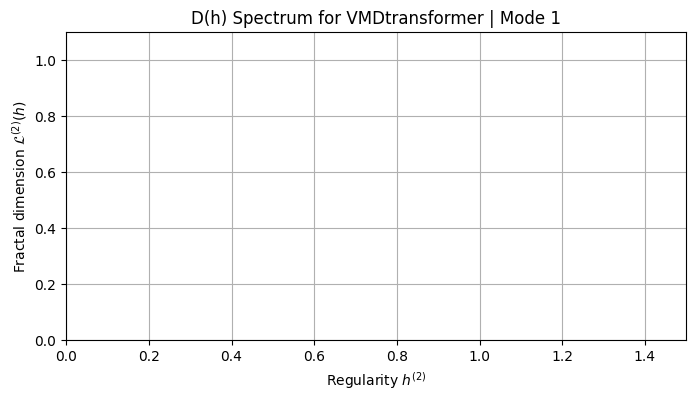


🔍 Applying MFA to VMDtransformer | Mode 2 — Length: 82500


<Figure size 800x400 with 0 Axes>

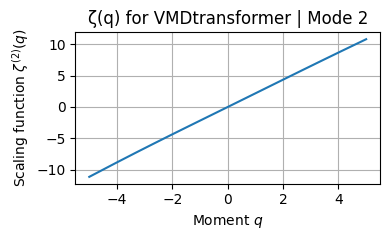

<Figure size 800x400 with 0 Axes>

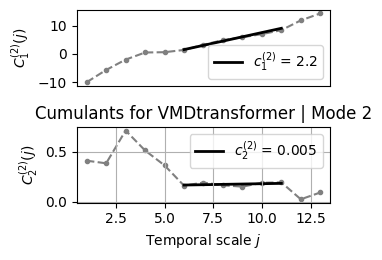

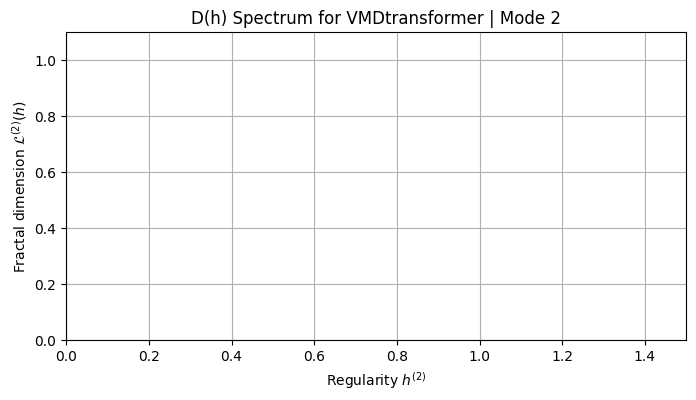


🔍 Applying MFA to VMDtransformer | Mode 3 — Length: 82500


<Figure size 800x400 with 0 Axes>

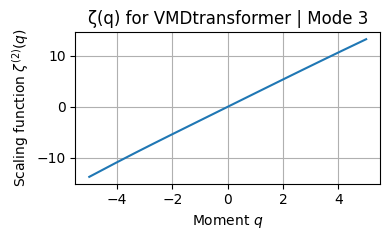

<Figure size 800x400 with 0 Axes>

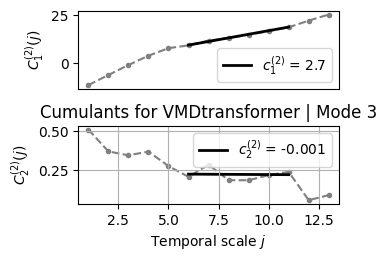

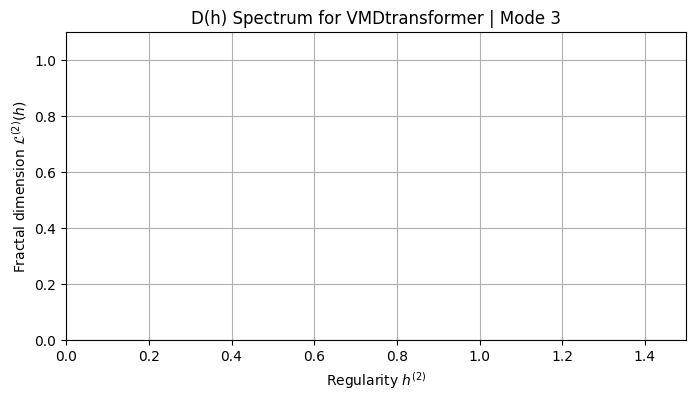


🔍 Applying MFA to VMDtransformer | Mode 4 — Length: 82500


<Figure size 800x400 with 0 Axes>

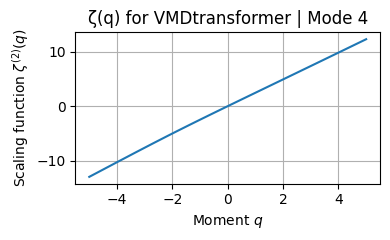

<Figure size 800x400 with 0 Axes>

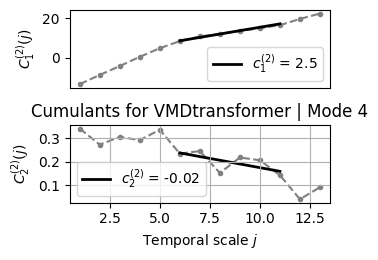

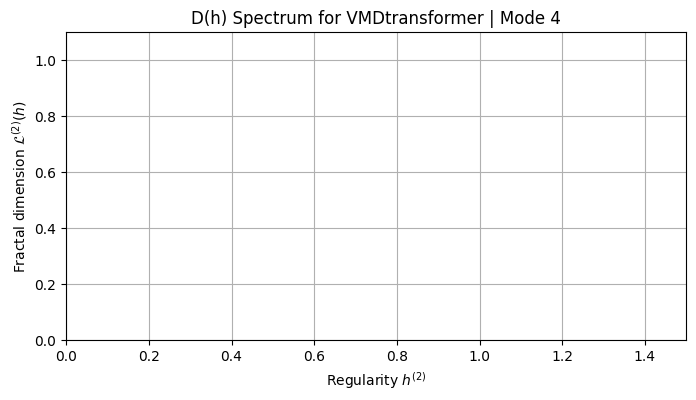


🔍 Applying MFA to VMDtransformer | Mode 5 — Length: 82500


<Figure size 800x400 with 0 Axes>

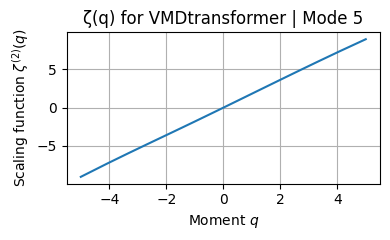

<Figure size 800x400 with 0 Axes>

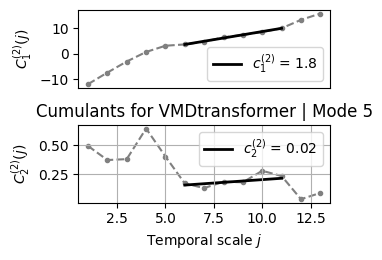

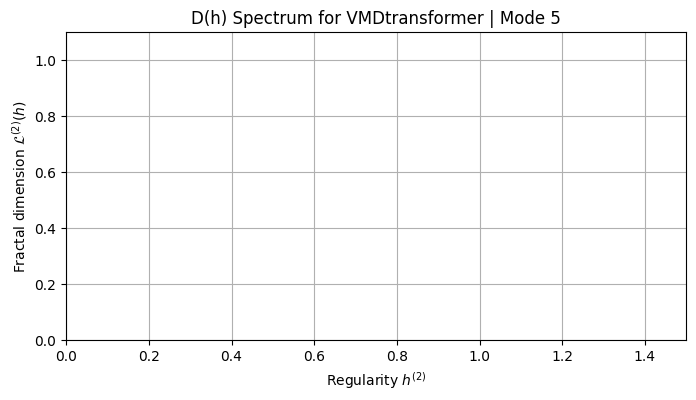


🔍 Applying MFA to VMDtransformer | Mode 6 — Length: 82500


<Figure size 800x400 with 0 Axes>

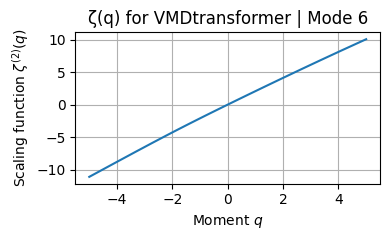

<Figure size 800x400 with 0 Axes>

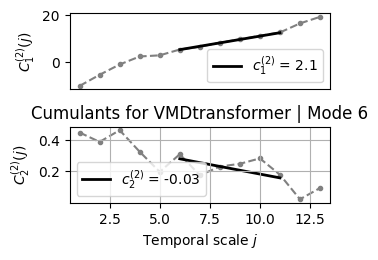

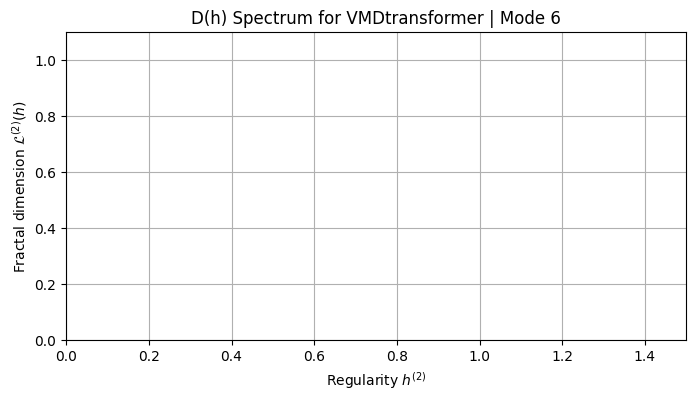


🔍 Applying MFA to VMDtransformer | Mode 7 — Length: 82500


<Figure size 800x400 with 0 Axes>

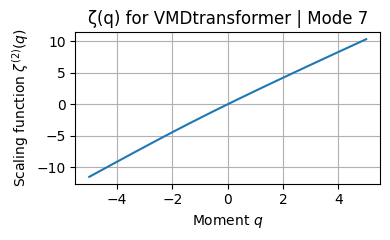

<Figure size 800x400 with 0 Axes>

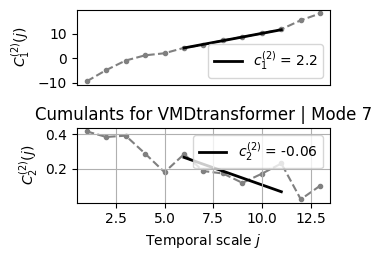

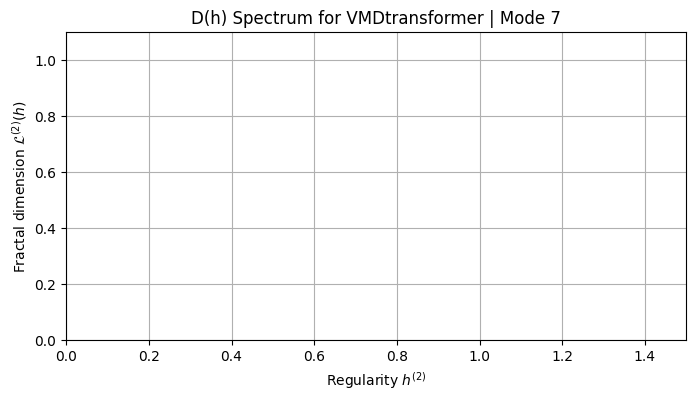

In [ ]:
load_modes_and_apply_mfa("mrw_with_fbm_modes.npy")


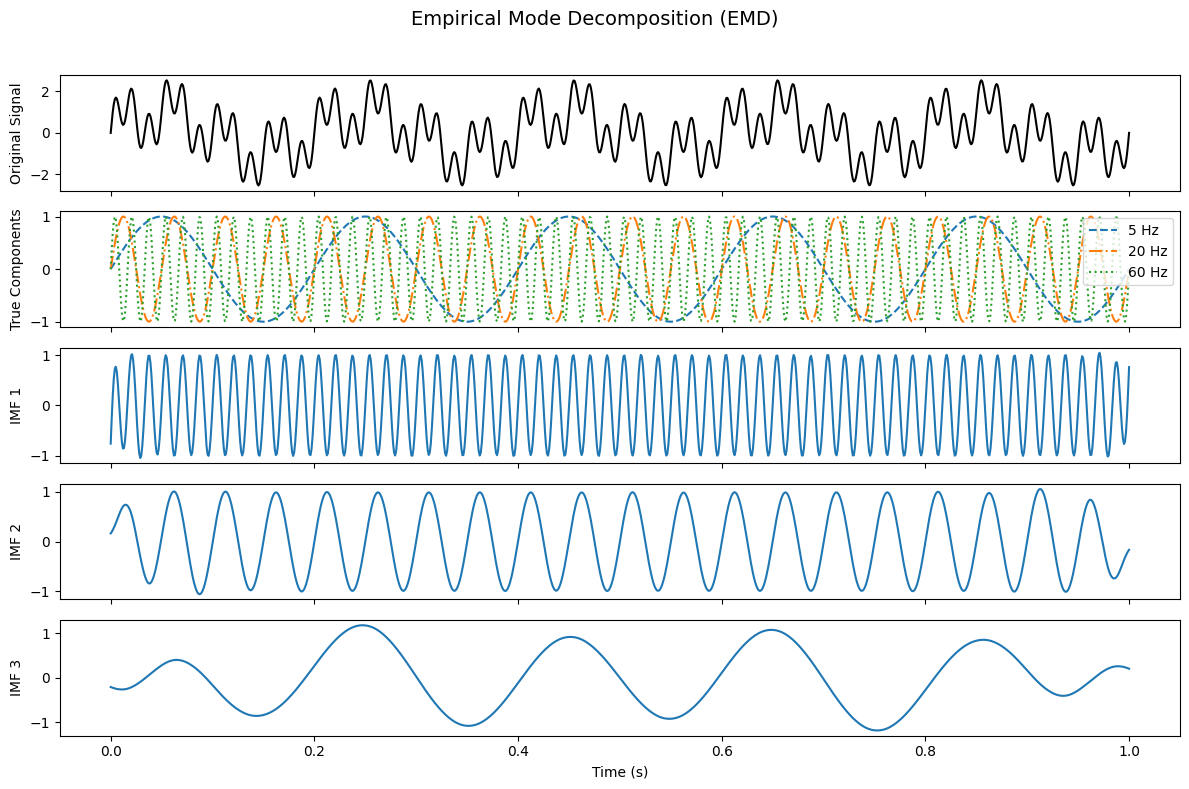

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PyEMD import EMD

# Time axis
fs = 1000
t = np.linspace(0, 1, fs)

# True components
c1 = np.sin(2 * np.pi * 5 * t)
c2 = np.sin(2 * np.pi * 20 * t)
c3 = np.sin(2 * np.pi * 60 * t)
signal = c1 + c2 + c3

# EMD decomposition
emd = EMD()
imfs = emd.emd(signal, t)

# Plot
fig, axes = plt.subplots(5, 1, figsize=(12, 8), sharex=True)
fig.suptitle("Empirical Mode Decomposition (EMD)", fontsize=14)

axes[0].plot(t, signal, color='black')
axes[0].set_ylabel("Original Signal")

axes[1].plot(t, c1, label='5 Hz', linestyle='--')
axes[1].plot(t, c2, label='20 Hz', linestyle='-.')
axes[1].plot(t, c3, label='60 Hz', linestyle=':')
axes[1].legend()
axes[1].set_ylabel("True Components")

for i in range(min(3, imfs.shape[0])):
    axes[i+2].plot(t, imfs[i])
    axes[i+2].set_ylabel(f"IMF {i+1}")

axes[-1].set_xlabel("Time (s)")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'figures/Background/EMD_Colorblind.png'

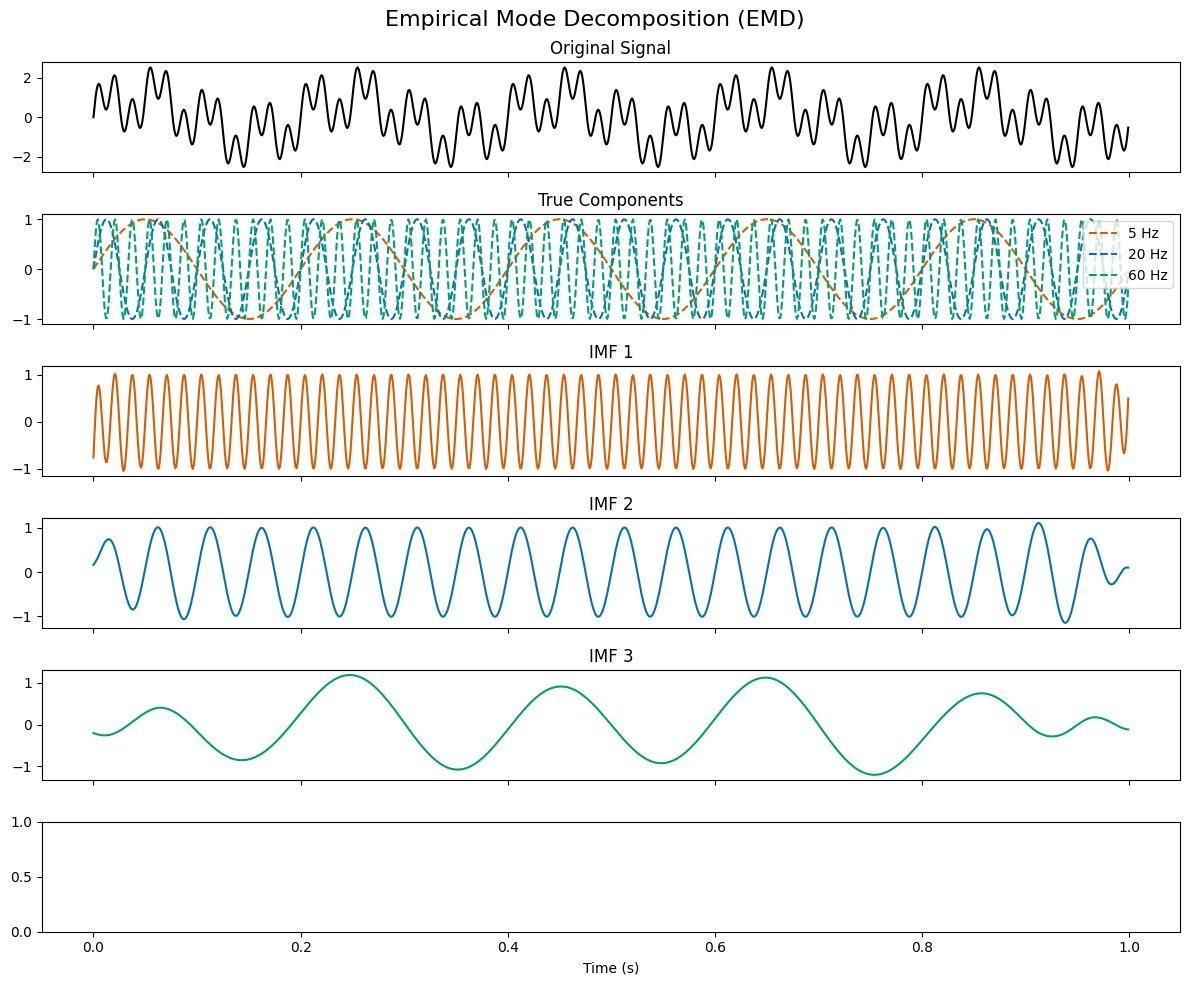

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PyEMD import EMD

# Colorblind-friendly palette
colors = ['#D55E00', '#0072B2', '#009E73']

# Generate synthetic signal
fs = 1000
t = np.linspace(0, 1, fs, endpoint=False)
comp1 = np.sin(2 * np.pi * 5 * t)
comp2 = np.sin(2 * np.pi * 20 * t)
comp3 = np.sin(2 * np.pi * 60 * t)
signal = comp1 + comp2 + comp3

# Apply EMD
emd = EMD()
IMFs = emd(signal)

# Plot EMD
fig, axs = plt.subplots(6, 1, figsize=(12, 10), sharex=True)
fig.suptitle("Empirical Mode Decomposition (EMD)", fontsize=16)
axs[0].plot(t, signal, color='black')
axs[0].set_title("Original Signal")
axs[1].plot(t, comp1, linestyle='--', color=colors[0], label='5 Hz')
axs[1].plot(t, comp2, linestyle='--', color=colors[1], label='20 Hz')
axs[1].plot(t, comp3, linestyle='--', color=colors[2], label='60 Hz')
axs[1].legend()
axs[1].set_title("True Components")
for i in range(3):
    axs[i+2].plot(t, IMFs[i], color=colors[i])
    axs[i+2].set_title(f"IMF {i+1}")
axs[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.savefig("figures/Background/EMD_Colorblind.png")

# Apply VMD
u, u_hat, omega = VMD(signal, alpha=2000, tau=0, K=3, DC=0, init=1, tol=1e-6)

# Plot VMD
fig, axs = plt.subplots(6, 1, figsize=(12, 10), sharex=True)
fig.suptitle("Variational Mode Decomposition (VMD)", fontsize=16)
axs[0].plot(t, signal, color='black')
axs[0].set_title("Original Signal")
axs[1].plot(t, comp1, linestyle='--', color=colors[0], label='5 Hz')
axs[1].plot(t, comp2, linestyle='--', color=colors[1], label='20 Hz')
axs[1].plot(t, comp3, linestyle='--', color=colors[2], label='60 Hz')
axs[1].legend()
axs[1].set_title("True Components")
for i in range(3):
    axs[i+2].plot(t, u[i], color=colors[i])
    axs[i+2].set_title(f"Mode {i+1}")
axs[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.savefig("figures/Background/VMD_Colorblind.png")
